In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split


# Training Dataset

First, organize the training dataset, and split into 'train' and 'val' sets for training and cross validation.

In [3]:
# Read the metadata.csv file into a pandas DataFrame
# path = '/content/drive/My Drive/DukeStudies/548L_MLI_Project/Skin_Lesion_Classification/HAM10000data/'
path = '/content/drive/MyDrive/Sp23/BME548L_Machine_Learning_and_Imaging/548L_MLI_Project/Skin_Lesion_Classification/HAM10000data/'


In [ ]:
df = pd.read_csv(path+'HAM10000_metadata.csv')
display(df.shape)

(10015, 8)

Category  Count Percentage
      nv   6705     66.95%
     mel   1113     11.11%
     bkl   1099     10.97%
     bcc    514      5.13%
   akiec    327      3.27%
    vasc    142      1.42%
      df    115      1.15%


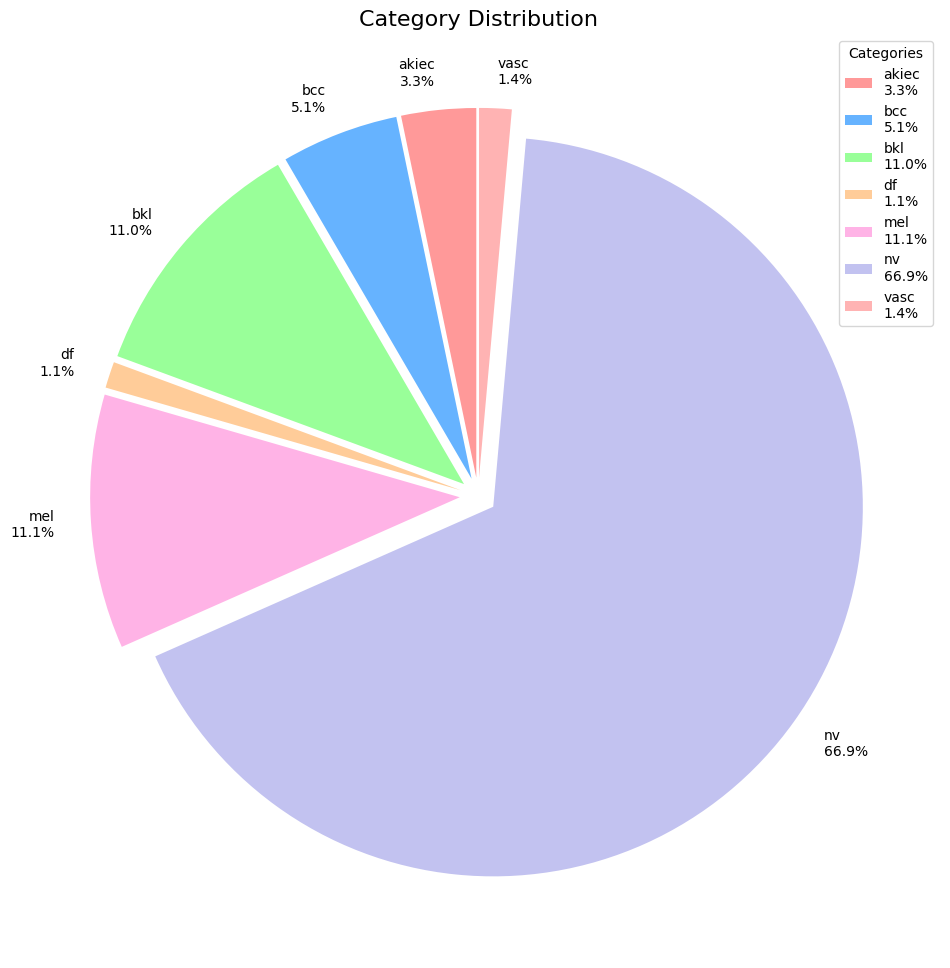

In [ ]:
category_counts = df['dx'].value_counts().sort_index()

# Calculate the percentage of each category
category_percentages = category_counts / category_counts.sum() * 100

# Create a pandas DataFrame with the category counts and percentages
category_table = pd.DataFrame({'Category': category_counts.index, 'Count': category_counts, 'Percentage': category_percentages})

# Sort the table by category count in descending order
category_table = category_table.sort_values('Count', ascending=False)

# Format the Percentage column to include the percentage sign
category_table['Percentage'] = category_table['Percentage'].apply(lambda x: f'{x:.2f}%')

# Print the table with a nice format
print(category_table.to_string(index=False))

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 12))

# Create a list of labels for each category with the percentage value
category_labels = [f"{label}\n{percentage:.1f}%" for label, percentage in zip(category_counts.index, category_percentages)]

# Create a pie chart with custom colors and explode
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ffb3e6','#c2c2f0','#ffb3b3']
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
ax.pie(category_counts, colors=colors, labels=category_labels, startangle=90, explode=explode)

# Add a title
ax.set_title('Category Distribution', fontsize=16)

# Add a legend
ax.legend(title='Categories', loc='upper right')

# Show the plot
plt.show()

(1511, 8)

Category  Count Percentage
      nv    908     60.09%
     bkl    217     14.36%
     mel    171     11.32%
     bcc     93      6.15%
      df     44      2.91%
   akiec     43      2.85%
    vasc     35      2.32%


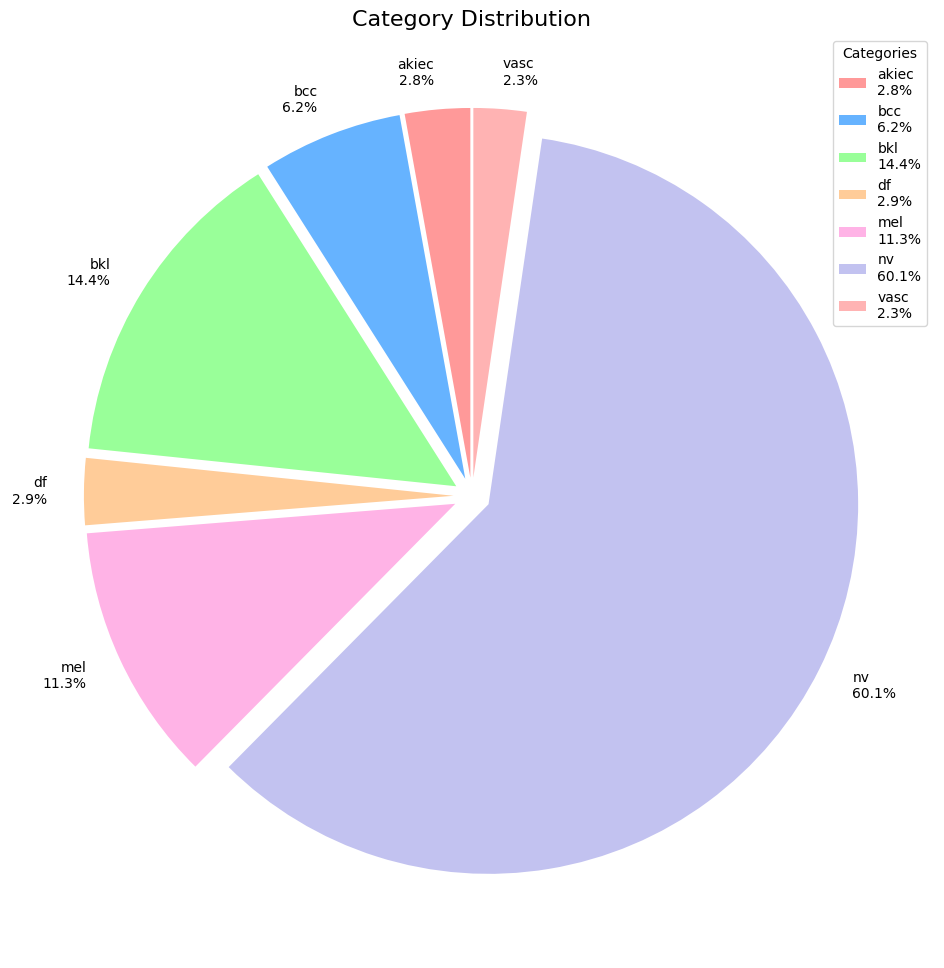

In [4]:
df = pd.read_csv(path+'Test_Ground_Truth.csv')
display(df.shape)

category_counts = df['dx'].value_counts().sort_index()

# Calculate the percentage of each category
category_percentages = category_counts / category_counts.sum() * 100

# Create a pandas DataFrame with the category counts and percentages
category_table = pd.DataFrame({'Category': category_counts.index, 'Count': category_counts, 'Percentage': category_percentages})

# Sort the table by category count in descending order
category_table = category_table.sort_values('Count', ascending=False)

# Format the Percentage column to include the percentage sign
category_table['Percentage'] = category_table['Percentage'].apply(lambda x: f'{x:.2f}%')

# Print the table with a nice format
print(category_table.to_string(index=False))

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 12))

# Create a list of labels for each category with the percentage value
category_labels = [f"{label}\n{percentage:.1f}%" for label, percentage in zip(category_counts.index, category_percentages)]

# Create a pie chart with custom colors and explode
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#ffb3e6','#c2c2f0','#ffb3b3']
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
ax.pie(category_counts, colors=colors, labels=category_labels, startangle=90, explode=explode)

# Add a title
ax.set_title('Category Distribution', fontsize=16)

# Add a legend
ax.legend(title='Categories', loc='upper right')

# Show the plot
plt.show()

In [ ]:
listdir = os.listdir

contents = listdir(path+'Images_Train/')

# Filter the results to only include image files
image_files = [file for file in contents if file.endswith('.jpg')]

# Convert the results to a list
image_file_names = list(image_files)
len(image_file_names)

10015

In [ ]:
image_file_names[1] # To check on the image file name construction

'ISIC_0033323.jpg'

The file name of images is encoded as **image_id.jpg**.

In [ ]:
image_paths = []

for image_id in df['image_id']:
    image_path = os.path.join(path+'Images_Train', image_id + '.jpg')
    image_paths.append(image_path)

In [ ]:
df['image_path'] = image_paths
df.shape

(10015, 9)

In [ ]:
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,vidir_modern,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,vidir_modern,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,vidir_modern,/content/drive/MyDrive/Sp23/BME548L_Machine_Le...


In [ ]:
df.to_csv(path+'train_metadata.csv')

In [ ]:
image_ids = df['image_id']
image_paths = df['image_path']

(600, 450)


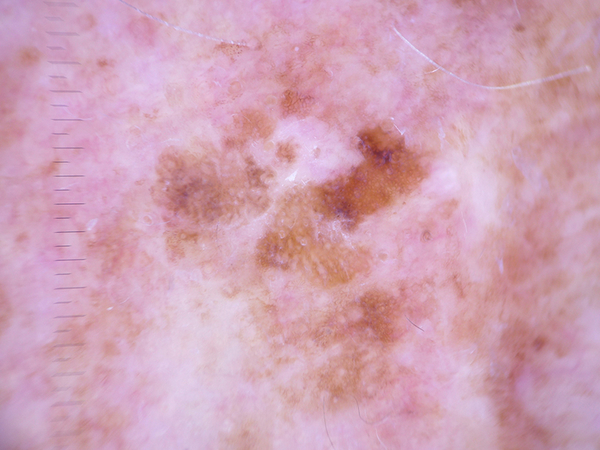

In [ ]:
# loading a sample image
sample_image = Image.open(image_paths[0])
print(sample_image.size)
sample_image

# Test Dataset

Now, let's do the same to the test dataset

(1511, 8)

(1511, 9)

(600, 450)


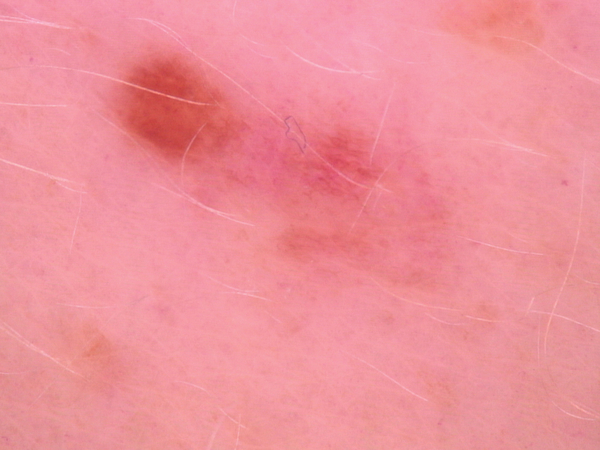

In [ ]:
df_test = pd.read_csv(path+'Test_Ground_Truth.csv')
display(df_test.shape)

# Get the contents of the subset
contents_test = listdir(path+'Images_Test/')

# Filter the results to only include image files
image_files_test = [file for file in contents_test if file.endswith('.jpg')]

# Convert the results to a list
image_file_names_test = list(image_files_test)

image_paths_test = []

for image_id in df_test['image_id']:
    image_path_test = os.path.join(path+'Images_Test', image_id + '.jpg')
    image_paths_test.append(image_path_test)

df_test['image_path'] = image_paths_test
display(df_test.shape)

df_test.to_csv(path+'test_metadata.csv')

image_ids_test = df_test['image_id']
image_paths_test = df_test['image_path']

# loading a sample image
sample_image_test = Image.open(image_paths_test[0])
print(sample_image_test.size)
sample_image_test
